In [1]:
import importlib
from pathlib import Path
import itertools
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import scipy.stats
from statsmodels import api as sm
import pyBigWig
import logomaker
import json

from Modules import utils, plot_utils

2023-06-13 12:15:10.484066: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)


In [4]:
species = 'SCerevisiae'

In [10]:
model = tf.keras.models.load_model(Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), custom_objects={'correlate': correlate})
model.loss

<function tensorflow.python.keras.losses.mean_absolute_error(y_true, y_pred)>

: 

In [35]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    # Replacing inf:
    # Replace inf by max value
    # x_[np.isinf(x_)] = np.max(x_[np.isfinite(x_)])
    # Etienne's way
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    # Workaround Etienne's way to avoid inf in cohesine myco
    q99_5, q98 = np.percentile(x_, [99.5, 98])
    if np.isnan(q99_5) :
        x_[np.isinf(x_)] = q98
    else:
        x_[np.isinf(x_)] = q99_5
    # Compute log
    x_ = np.log2(x_ + 1)
    return x_

def load_yeast_bw(filename, bact='myco', romantoint=False, process=None):
    # Load bigwig
    labels = utils.load_bw(filename)
    # Change chromosome names
    if romantoint:
        for key in list(labels.keys()):
            if key[:3] == 'chr':
                new_key = 'chr' + format(utils.roman_to_int(key[3:]), '02d')
                labels[new_key] = labels.pop(key)
    if bact == 'myco':
        chr_id = list({'Mmm_Linear_740kb.fa', 'Mmmyco'}.intersection(labels.keys()))
        assert len(chr_id) == 1
        labels['myco'] = labels.pop(chr_id[0])
    elif bact == 'pneu':
        labels['pneu'] = labels.pop('Pneu300')
    # Remove unwanted chromosomes
    for key in list(labels.keys()):
        if key[:3] != 'chr' and key != bact:
            labels.pop(key)
    # Transform data
    if process is not None:
        if process == 'conv':
            process = lambda x: utils.moving_average(x, 21, keepsize=True)
        elif process == 'log':
            process = lambda x: np.log2(1 + x)
        for key, value in labels.items():
            labels[key] = process(value)
    # Normalize in CPM
    thres = sum(v.sum() for v in labels.values()) / 1e6
    for key, value in labels.items():
        labels[key] = value / thres
    return labels

def load_yeast_nuc(mycofile=None, pneufile=None, asdict=True, priority='myco', process='conv'):
    if mycofile is None:
        mycofile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw'
    if pneufile is None:
        pneufile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw'
    # Load bigwigs
    labels_myco = load_yeast_bw(mycofile, bact='myco', process=process)
    labels_pneu = load_yeast_bw(pneufile, bact='pneu', process=process)
    # Get labels from priority file
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value
        labels['pneu'] = labels_pneu['pneu']
    else:
        for key, value in labels_pneu.items():
            labels[key] = value
        labels['myco'] = labels_myco['myco']
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                    asdict=True, priority='myco'):
    # Get log ratios
    labels_myco = {}
    for key, value in labels_ipmyco.items():
        labels_myco[key] = log(value / labels_ctrlmyco[key])
    thres_myco = sum(v.sum() for v in labels_myco.values()) / 1e6
    labels_pneu = {}
    for key, value in labels_ippneu.items():
        labels_pneu[key] = log(value / labels_ctrlpneu[key])
    thres_pneu = sum(v.sum() for v in labels_pneu.values()) / 1e6
    # Get labels from priority file, and normalize in CPM
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value / thres_myco
        labels['pneu'] = labels_pneu['pneu'] / thres_pneu
    else:
        for key, value in labels_pneu.items():
            labels[key] = value / thres_pneu
        labels['myco'] = labels_myco['myco'] / thres_myco
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_coh(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='pneu'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco', romantoint=True)
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco', romantoint=True)
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

def load_yeast_pol(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='myco'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco')
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco')
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

# labels_nuc_yeast, labels_nuc_myco, labels_nuc_pneu = load_yeast_nuc(asdict=False, process=None)
# labels_coh_yeast, labels_coh_myco, labels_coh_pneu = load_yeast_coh(asdict=False)
# labels_pol_yeast, labels_pol_myco, labels_pol_pneu = load_yeast_pol(asdict=False)
labels_nuc = load_yeast_nuc()
labels_coh = load_yeast_coh()
labels_pol = load_yeast_pol()

/tmp/ipykernel_1621478/3145760620.py:86: RuntimeWarning: divide by zero encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1621478/3145760620.py:86: RuntimeWarning: invalid value encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_1621478/3145760620.py:90: RuntimeWarning: divide by zero encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])
/tmp/ipykernel_1621478/3145760620.py:90: RuntimeWarning: invalid value encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])


In [46]:
max_nuc = np.max([np.max(v) for v in labels_nuc.values()])
max_coh = np.max([np.max(v) for v in labels_coh.values()])
max_pol = np.max([np.max(v) for v in labels_pol.values()])
print(max_nuc, max_coh, max_pol)
{k: np.max(v) for k, v in labels_nuc.items()}
{k: np.max(v) for k, v in labels_coh.items()}
# {k: np.max(v) for k, v in labels_pol.items()}

54.476128 1.0072502 0.68775374


{'chr01': 0.49261805,
 'chr02': 0.5665447,
 'chr03': 0.5001005,
 'chr04': 0.4937488,
 'chr05': 0.6099528,
 'chr06': 0.50966746,
 'chr07': 0.5758628,
 'chr08': 0.62615305,
 'chr09': 0.47404206,
 'chr10': 0.50311136,
 'chr11': 0.67251915,
 'chr12': 1.0072502,
 'chr13': 0.51249945,
 'chr14': 0.5261845,
 'chr15': 0.5179289,
 'chr16': 0.5935781,
 'pneu': 0.49384093,
 'myco': 0.5101825}

<AxesSubplot:ylabel='Count'>

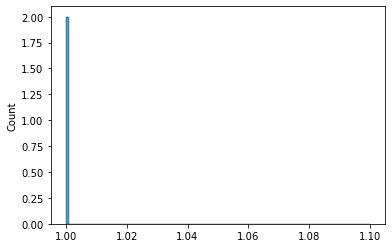

In [65]:
sns.histplot(np.concatenate([np.clip(v, None, 1) for k, v in labels_coh.items() if k[:3] == 'chr']), bins=100, binrange=(1, 1.1))

In [32]:
np.savez_compressed(Path(data_dir, species, 'models_etienne', 'labels_nuc.npz'), **labels_nuc)
np.savez_compressed(Path(data_dir, species, 'models_etienne', 'labels_coh.npz'), **labels_coh)
np.savez_compressed(Path(data_dir, species, 'models_etienne', 'labels_pol.npz'), **labels_pol)

In [66]:
np.savez_compressed(Path(data_dir, species, 'models_etienne', 'labels_nuc_clipped.npz'), **{k: np.clip(v, None, 1) for k, v in labels_nuc.items()})

In [4]:
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303_ATCG.npz')) as f:
    all_one_hots = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb_ATCG.npz')) as f:
    all_one_hots['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300_ATCG.npz')) as f:
    all_one_hots['pneu'] = f['chr1']
np.savez(Path(data_dir, species, 'genome', 'bacterie', 'W303_myco_pneu_ATCG.npz'), **all_one_hots)